## Offline

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob  
from copy import deepcopy
from random import sample
import tkinter as tk
from warnings import warn
import time

# Camera geometric calibration
Camera calibration is used to obtain the camera parameters:

In [2]:
# Global variables
edges = []
edges_count = 0
current_image = None
images_temp = []

square_size = 25
chessboard_shape = (9,6)
train_images_path = 'train_images2'
test_images_path = 'test_images'
plots_path = 'plots'
video_path = 'video/chessboard.mp4'

VIDEO = True

In [3]:
def show_warning(message_id):
    # Define the possible messages
    messages = {
        'not_4_edges': "You didn't select enough edges!",
        'train_empty': "Train image folder is empty!",
        'test_empty': "Test image folder is empty!",
    }

    # Fetch the appropriate message
    message = messages.get(message_id, "Unknown Warning")

    # Create the main window
    root = tk.Tk()
    root.title("Warning")

    # Create a label for the message
    label = tk.Label(root, text=message, padx=20, pady=20)
    label.pack()

    # Start the GUI event loop
    root.mainloop()

In [4]:
def manual_corners_selection(event, x, y, flags, params):
    global edges, edges_count, current_image, images_temp

    if event == cv2.EVENT_LBUTTONDOWN and edges_count < 4:
        edges.append((x, y))  # Append the new point
        images_temp.append(deepcopy(current_image))
        edges_count += 1

        label = str(edges_count)
        cv2.putText(current_image, label, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

        # Draw the circle on the new point
        cv2.circle(current_image, edges[edges_count - 1], 3, (255, 0, 0), -1)

        # Draw line to the previous point if more than one point is selected
        if edges_count > 1:
            cv2.line(current_image, edges[edges_count - 2], edges[edges_count - 1], (255, 0, 0), 2, cv2.LINE_AA)
        
        # Draw line to the first point if four points are selected
        if edges_count == 4:
            cv2.line(current_image, edges[0], edges[-1], (255, 0, 0), 2, cv2.LINE_AA)

        cv2.imshow("Manual Corners Selection", current_image)

    elif event == cv2.EVENT_RBUTTONDOWN and edges_count > 0:
        edges_count -= 1
        edges.pop()  # Remove the last point
        current_image = images_temp[edges_count]

        cv2.imshow("Manual Corners Selection", current_image)

In [5]:
def sort_edges(corners):
    # Calculate the centroid of the corners
    centroid = np.mean(corners, axis=0)

    # Sort corners and determine their relative position to the centroid
    top = sorted([corner for corner in corners if corner[1] < centroid[1]], key=lambda point: point[0])
    bottom = sorted([corner for corner in corners if corner[1] >= centroid[1]], key=lambda point: point[0], reverse=True)

    # Concatenate top and bottom points
    return np.array(top + bottom, dtype='float32')

In [6]:
def interpolate_chessboard_corners():
    global edges, edges_count, chessboard_shape, current_image
    
    if edges_count != 4:
        show_warning('not_4_edges')
    
    edges = sort_edges(edges)
    print(edges)
    

    # Calculate the maximum width and height    
    max_width = max(np.linalg.norm(edges[0] - edges[1]), 
                    np.linalg.norm(edges[2] - edges[3]))
    max_height = max(np.linalg.norm(edges[1] - edges[2]), 
                     np.linalg.norm(edges[3] - edges[0]))

    # Define the mapping coordinates for perspective transform
    dest_points = np.float32([
                             [0, 0],
                             [max_width - 1, 0],
                             [max_width - 1, max_height - 1],
                             [0, max_height - 1]])
    

    # Compute the perspective transform matrix
    p_matrix = cv2.getPerspectiveTransform(edges.astype(np.float32), dest_points)
    inverted_p_matrix = np.linalg.inv(p_matrix)

    # Horizontal and vertical step
    w_step = max_width / (chessboard_shape[1] - 1)
    h_step = max_height / (chessboard_shape[0] - 1)

    projected_corners = []

    # Compute each projected point
    for y in range(0, chessboard_shape[0]):
        for x in range(0, chessboard_shape[1]):
            point = np.array([x * w_step, y * h_step, 1])
            point = np.matmul(inverted_p_matrix, point)
            # Divide each point by its Z component
            point *= (1.0 / point[2])
            # Append only the first 2 elements of each point
            projected_corners.append(point[0:2])

    return np.array(projected_corners, dtype='float32')

In [7]:
def uniform_images_dimensions(directory):
    # Get list of image file paths
    image_paths = glob.glob(os.path.join(directory, "*.jpg")) 
    
    # Initialize variables to store the dimensions
    min_width, min_height = np.inf, np.inf
    dimensions_set = set()
    
    # First pass to find dimensions and check uniformity
    for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is not None:
            h, w = img.shape[:2]
            dimensions_set.add((h, w))
            min_width, min_height = min(min_width, w), min(min_height, h)

    # Check if all images have the same dimensions
    if len(dimensions_set) == 1:
        print("All images have the same dimensions.")
        return img.shape
    else:
        print("Not all images have the same dimensions. Proceeding to crop.")

    images_shape = ()
    
    # Second pass to crop images
    for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is not None:
            h, w = img.shape[:2]
            if h > min_height or w > min_width:
                # Calculate crop dimensions
                top = (h - min_height) // 2
                bottom = h - min_height - top
                left = (w - min_width) // 2
                right = w - min_width - left

                # Crop and save the image
                cropped_img = img[top:h-bottom, left:w-right]
                cv2.imwrite(image_path, cropped_img)
                
    return cropped_img.shape

In [8]:
def plot_intrinsics_comparisons(mtxs, stds, out_dir_path):
    if len(mtxs) != len(stds):
        warn("[PLOT_INTRINSICS]: No plot will be generated because the number of camera intrinsics and standard deviations must be the same!")
        return False

    # Create some lists containing the intrinsic parameters
    x_focal_lengths = np.array([cm[0][0] for cm in mtxs])
    y_focal_lengths = np.array([cm[1][1] for cm in mtxs])
    x_center = np.array([cm[0][2] for cm in mtxs])
    y_center = np.array([cm[1][2] for cm in mtxs])

    # The x-axis values will correspond to the indices of the calibrations
    x_axis = np.arange(len(mtxs))

    # Create some lists containing the standard deviations for each intrinsic parameter
    x_focal_lengths_stds = np.array([std[0][0] for std in stds])
    y_focal_lengths_stds = np.array([std[1][0] for std in stds])
    x_centers_stds = np.array([std[2][0] for std in stds])
    y_centers_stds = np.array([std[3][0] for std in stds])

    # Create a plot with 4 rows and one column
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(6, 15))

    # Define bar width
    bar_width = 0.35

    # Plot the results as bars
    ax[0].set_title("Focal Length (Fx)")
    ax[0].bar(x_axis, x_focal_lengths, bar_width, color='black')
    ax[0].errorbar(x_axis, x_focal_lengths, yerr=x_focal_lengths_stds, fmt='none', ecolor='r', capsize=5)

    ax[1].set_title("Focal Length (Fy)")
    ax[1].bar(x_axis, y_focal_lengths, bar_width, color='black')
    ax[1].errorbar(x_axis, y_focal_lengths, yerr=y_focal_lengths_stds, fmt='none', ecolor='r', capsize=5)

    ax[2].set_title("Center Point (Cx)")
    ax[2].bar(x_axis, x_center, bar_width, color='black')
    ax[2].errorbar(x_axis, x_center, yerr=x_centers_stds, fmt='none', ecolor='r', capsize=5)

    ax[3].set_title("Center Point (Cy)")
    ax[3].bar(x_axis, y_center, bar_width, color='black')
    ax[3].errorbar(x_axis, y_center, yerr=y_centers_stds, fmt='none', ecolor='r', capsize=5)

    # Adjust the x-axis to display calibration labels
    ax[0].set_xticks(x_axis)
    ax[0].set_xticklabels(["Calibration " + str(i) for i in range(len(mtxs))])
    
    ax[1].set_xticks(x_axis)
    ax[1].set_xticklabels(["Calibration " + str(i) for i in range(len(mtxs))])
    
    ax[2].set_xticks(x_axis)
    ax[2].set_xticklabels(["Calibration " + str(i) for i in range(len(mtxs))])
    
    ax[3].set_xticks(x_axis)
    ax[3].set_xticklabels(["Calibration " + str(i) for i in range(len(mtxs))])

    # Save the plot in a .pdf file
    plt.savefig(os.path.join(out_dir_path, "intrinsic_params_runs_comparison.pdf"))

    return True

In [9]:
def log_camera_intrinsics_confidence(mtx, ret, std, calibration_name="", rounding=3):
    title = "Confidence Of Estimated Camera Parameters" if calibration_name == "" \
        else "[" + calibration_name + "] Confidence Of Estimated Camera Parameters"

    print(title)
    print("Overall RMS Re-Projection Error", round(ret, 3))
    print("Focal Length (Fx)", round(mtx[0][0], rounding), "\tSTD +/-", round(std[0][0], rounding))
    print("Focal Length (Fy)", round(mtx[1][1], rounding), "\tSTD +/-", round(std[1][0], rounding))
    print("Camera Center (Cx)", round(mtx[0][2], rounding), "\tSTD +/-", round(std[2][0], rounding))
    print("Camera Center (Cy)", round(mtx[1][2], rounding), "\tSTD +/-", round(std[3][0], rounding), "\n")


In [10]:
def estimate_camera_params(images_info, image_shape, pattern_shape, square_size):

    default_object_points = np.zeros((pattern_shape[0] * pattern_shape[1], 3), dtype=np.float32)
    default_object_points[:, :2] = np.mgrid[0:pattern_shape[0], 0:pattern_shape[1]].T.reshape(-1, 2) \
                                   * square_size

    image_points = list(map(lambda info: info[1], images_info))
    object_points = [default_object_points for _ in range(len(image_points))]

    return cv2.calibrateCameraExtended(object_points, image_points, image_shape, None, None)

In [11]:
def calibrate():
    if VIDEO == False:
        global current_image, edges, edges_count, chessboard_shape, train_images_path, test_images_path, square_size, plots_path
        
        train_images_path_list = glob.glob(os.path.join(train_images_path,'*.jpg'))
        # test_images_path_list = glob.glob(os.path.join(test_images_path,'*.jpg'))
        
        if not train_images_path_list:
            show_warning('train_empty')
        
        # if not train_images_path_list:
        #     show_warning('test_empty')
        
        train_image_shape = uniform_images_dimensions(train_images_path)[:2]
        
        # test_image_shape = uniform_images_dimensions(test_images_path)
            
        images_info = []
        
        for image_path in train_images_path_list:
            current_image = cv2.imread(image_path)
            
            
            current_image = cv2.resize(current_image, (0,0), fx=0.5, fy=0.5)
            
            if current_image is None:
                warn("Cannot load " + image_path + ". It will be skipped!")
                continue
        
            # Convert the picture to grayscale and try to detect the chessboard corners automatically with cv2 function
            gray = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
            found, coords = cv2.findChessboardCorners(gray, chessboard_shape, flags=cv2.CALIB_CB_ADAPTIVE_THRESH +
                                                                                    cv2.CALIB_CB_NORMALIZE_IMAGE +
                                                                                    cv2.CALIB_CB_FAST_CHECK +
                                                                                    cv2.CALIB_CB_FILTER_QUADS)
            if not found:
                warn(f"Cannot detect corners for image {image_path}. The corners will need to be extracted manually!")

                # Keep a cache of the same picture
                images_temp.append(deepcopy(current_image))

                # Show the corner selection window
                cv2.imshow("Manual Corners Selection", current_image)
                cv2.setMouseCallback("Manual Corners Selection", manual_corners_selection)

                # Once the user is done then it's sufficient to press any key to proceed to the interpolation phase
                while True:
                    cv2.waitKey(0)
                    if edges_count == 4:
                        cv2.destroyAllWindows()
                        break

                # Corner interpolation phase
                coords = interpolate_chessboard_corners()

                # Set the current image equal to the first entry in the cache list
                current_image = images_temp[0]

                # Reset the cache, edges list and count
                images_temp.clear()
                edges = []
                edges_count = 0
        
        
            # Perform a refinement algorithm to the projected corner points
            term_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
            points = cv2.cornerSubPix(gray, np.array(coords).astype(np.float32), (11, 11), (-1, -1), term_criteria)
                
            images_info.append((found, points))
                        
            cv2.drawChessboardCorners(current_image, chessboard_shape, points, True)
            cv2.imshow('Checkerboard Corners', current_image)
            cv2.waitKey(350)
        
        cv2.destroyAllWindows()
        
                
        # Calibration run 1
        print('Starting Calibration 1')
        ret_1, mtx_1, dist_1, r_vecs_1, t_vecs_1, std_in_1, _, _ = estimate_camera_params(images_info, train_image_shape, chessboard_shape, square_size)


        # Calibration run 2
        images_info = list(filter(lambda info: info[0], images_info))
        print('Starting Calibration 2')
        ret_2, mtx_2, dist_2, r_vecs_2, t_vecs_2, std_in_2, _, _ = estimate_camera_params(sample(images_info, 10), train_image_shape, chessboard_shape, square_size)

        # Calibration run 3
        print('Starting Calibration 3')
        ret_3, mtx_3, dist_3, r_vecs_3, t_vecs_3, std_in_3, _, _ = estimate_camera_params(sample(images_info, 5), train_image_shape, chessboard_shape, square_size)

        log_camera_intrinsics_confidence(mtx_1, ret_1, std_in_1, "Calibration 1")
        log_camera_intrinsics_confidence(mtx_2, ret_2, std_in_2, "Calibration 2")
        log_camera_intrinsics_confidence(mtx_3, ret_3, std_in_3, "Calibration 3")
        
        plot_intrinsics_comparisons([mtx_1, mtx_2, mtx_3], [std_in_1, std_in_2, std_in_3], plots_path)
    
    else:
        
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("Error: Could not open video.")
            return

        images_info = []
        train_image_shape = None
        frame_counter = 0  # Initialize frame counter

        while True:
            ret, frame = cap.read()
            if not ret:
                break  # End of video

            frame_counter += 1

            # Resize for faster processing
            frame = cv2.resize(frame, (0,0), fx=0.5, fy=0.5)
            if train_image_shape is None:
                train_image_shape = frame.shape[:2][::-1]  # (width, height)

            # Convert the picture to grayscale
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Detect chessboard corners
            found, coords = cv2.findChessboardCorners(gray, chessboard_shape, flags=cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_FILTER_QUADS)
            if found:
                time.sleep(0.005)
                term_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
                coords = cv2.cornerSubPix(gray, coords, (11, 11), (-1, -1), term_criteria)
                images_info.append((found, coords))

                # Display corners
                cv2.drawChessboardCorners(frame, chessboard_shape, coords, found)
                cv2.imshow('Chessboard Corners', frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        cap.release()
        cv2.destroyAllWindows()
        
        images_info = images_info[0::20]
        
        print(frame_counter)
        print(len(images_info))

        # Calibration runs
        if images_info:
            print('Starting Calibration')
            # Calibration run 1
            print('Starting Calibration 1')
            ret_1, mtx_1, dist_1, r_vecs_1, t_vecs_1, std_in_1, _, _ = estimate_camera_params(images_info, train_image_shape, chessboard_shape, square_size)


            # Calibration run 2
            images_info = list(filter(lambda info: info[0], images_info))
            print('Starting Calibration 2')
            ret_2, mtx_2, dist_2, r_vecs_2, t_vecs_2, std_in_2, _, _ = estimate_camera_params(sample(images_info, 10), train_image_shape, chessboard_shape, square_size)

            # Calibration run 3
            print('Starting Calibration 3')
            ret_3, mtx_3, dist_3, r_vecs_3, t_vecs_3, std_in_3, _, _ = estimate_camera_params(sample(images_info, 5), train_image_shape, chessboard_shape, square_size)

            log_camera_intrinsics_confidence(mtx_1, ret_1, std_in_1, "Calibration 1")
            log_camera_intrinsics_confidence(mtx_2, ret_2, std_in_2, "Calibration 2")
            log_camera_intrinsics_confidence(mtx_3, ret_3, std_in_3, "Calibration 3")
            
            plot_intrinsics_comparisons([mtx_1, mtx_2, mtx_3], [std_in_1, std_in_2, std_in_3], plots_path)
    
        

1591
73
Starting Calibration
Starting Calibration 1
Starting Calibration 2
Starting Calibration 3
[Calibration 1] Confidence Of Estimated Camera Parameters
Overall RMS Re-Projection Error 1.024
Focal Length (Fx) 473.449 	STD +/- 1.209
Focal Length (Fy) 478.149 	STD +/- 1.189
Camera Center (Cx) 145.827 	STD +/- 1.591
Camera Center (Cy) 260.396 	STD +/- 2.209 

[Calibration 2] Confidence Of Estimated Camera Parameters
Overall RMS Re-Projection Error 1.154
Focal Length (Fx) 472.737 	STD +/- 3.605
Focal Length (Fy) 476.984 	STD +/- 3.99
Camera Center (Cx) 148.595 	STD +/- 6.054
Camera Center (Cy) 265.307 	STD +/- 8.03 

[Calibration 3] Confidence Of Estimated Camera Parameters
Overall RMS Re-Projection Error 0.183
Focal Length (Fx) 476.209 	STD +/- 1.278
Focal Length (Fy) 479.179 	STD +/- 1.294
Camera Center (Cx) 143.112 	STD +/- 1.226
Camera Center (Cy) 262.38 	STD +/- 1.605 



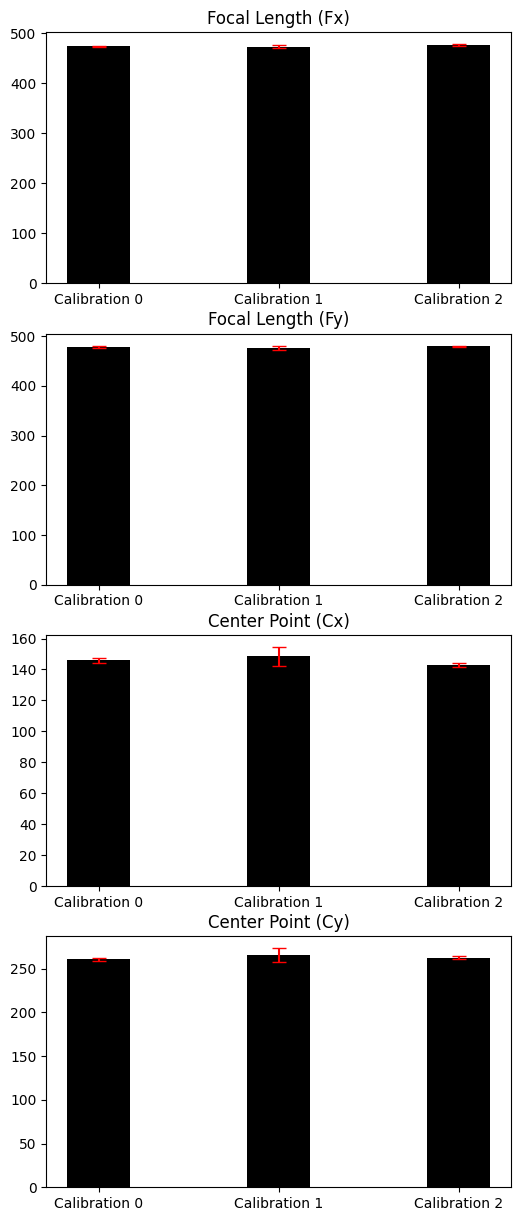

In [12]:
calibrate()